## Exploratory Data Analysis

The chest x-ray image data can be downloaded from [kaggle](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia?resource=download). As explained on the aforementioned kaggle site, the  dataset consists of a total of `5'863` x-ray images whose labels were generated by two expert physicians after unreadable and low-quality x-ray scans have been removed.

## Packages and Presets

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style="whitegrid")
import matplotlib.pyplot as plt
import os
from typing import Tuple
# opencv for image processing
import cv2
import tqdm

import warnings
warnings.filterwarnings("ignore")

# set max displayed number of columns of pandas dataframe
pd.set_option('display.max_columns', None)

## Reading in the Data

First, we have to read in the data using the function we wrote below. Note, that in the original dataset there are three labels: "Normal", "Bacterial Pneumonia" and "Viral Pneumonia". Thus, our read_image function provides the option to consider all three labels or to merge the last two labels into one. For the EDA we will consider both options (i.e. three labels and two labels), in the questions thereafter we will however only consider a binary classification problem (i.e. two labels).

In [2]:
def get_data(
    folder_path: str,
    pneumonia_subgroup: bool = False,
    img_size: Tuple[int, int] = (256, 256)
) -> Tuple[np.ndarray, np.ndarray]:

    """Reads the images and labels from the folder

    Args:
        folder_path (str): Path to the folder containing train/val/test images
        pneumonia_subgroup (bool, optional): Whether the different pneumonia types
                    should get different labels. Defaults to False.
        img_size (Tuple[int, int], optional): Rescaled size of images. Defaults to (256, 256).

    Returns:
        Tuple[np.ndarray, np.ndarray]: A tuple of the images as np.ndarray
                    and the labels as np.ndarray
    """
    images = []
    labels = []
    
    for i, subfolder in enumerate(["NORMAL", "PNEUMONIA"]):
        for file in tqdm.tqdm(
            os.listdir(os.path.join(folder_path, subfolder)),
            desc=f"Reading {subfolder} {folder_path.split('/')[-1]} images",
        ):

            # read in images
            image = cv2.imread(
                os.path.join(folder_path, subfolder, file)
            )
            # resize images to the same size
            image_resized = cv2.resize(image, img_size)
            images.append(image_resized)
            
            # if pneumonia_subgroup is True, we want to differentiate between
            # bacterial and viral pneumonia in the labels
            if pneumonia_subgroup and subfolder == "PNEUMONIA":
                if "bacteria" in file:
                    labels.append(i)
                else:
                    labels.append(i + 1)

            else:
                labels.append(i)
                
    return np.array(images), np.array(labels)

In [3]:
# train/validation images and 3 labels
train_images_all_types, train_labels_all_types = get_data(
    "data/chest_xray/train", pneumonia_subgroup=True
)
val_images_all_types, val_labels_all_types = get_data(
    "data/chest_xray/val", pneumonia_subgroup=True
)

# train/ validation images and 2 labels
train_images, train_labels = get_data("data/chest_xray/train")
val_images, val_labels = get_data("data/chest_xray/val")

Reading PNEUMONIA val images: 100%|██████████| 8/8 [00:00<00:00, 322.62it/s]


In [4]:
np.save('./train_images.npy', train_images)
np.save('./train_labels.npy', train_labels)
np.save('./val_images.npy', val_images)
np.save('./val_labels.npy', val_labels)

In [5]:
# explore shape of train/validation image and label arrays
print(f"Shape of train images: {train_images.shape}")
print(f"Shape of train labels: {train_labels.shape}")

print(f"Shape of val images: {val_images.shape}")
print(f"Shape of val labels: {val_labels.shape}")

Shape of train images: (5216, 256, 256, 3)
Shape of train labels: (5216,)
Shape of val images: (16, 256, 256, 3)
Shape of val labels: (16,)


Thus, our train dataset consists of `5'216` x-ray images, our validation set consists of `16` images.  Hence, due to the small size of the validation set, we should be careful to not overfit the model to the validation set.

## Checking Class Imbalances

[Text(0, 0, '74.29%')]

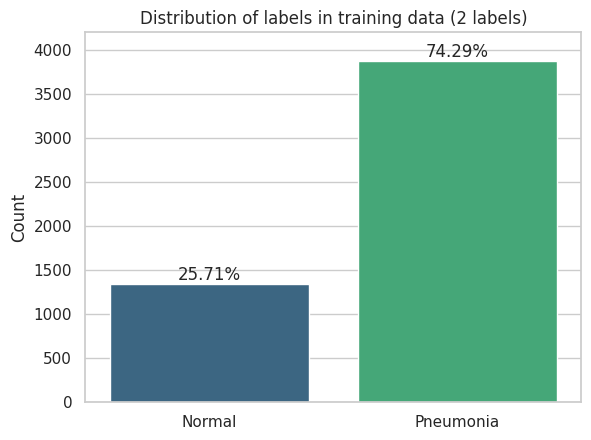

In [6]:
ax = sns.countplot(x=train_labels, palette="viridis")
plt.title("Distribution of labels in training data (2 labels)")
plt.xticks(ticks=[0, 1], labels=["Normal", "Pneumonia"])
plt.ylabel("Count")
plt.ylim(0, 4200)
# see https://stackoverflow.com/questions/76240680/how-do-i-add-a-percentage-to-a-countplot
ax.bar_label(ax.containers[0], fmt=lambda x: f"{x/len(train_labels) * 100:.2f}%")
ax.bar_label(ax.containers[1], fmt=lambda x: f"{x/len(train_labels) * 100:.2f}%")

[Text(0, 0, '25.79%')]

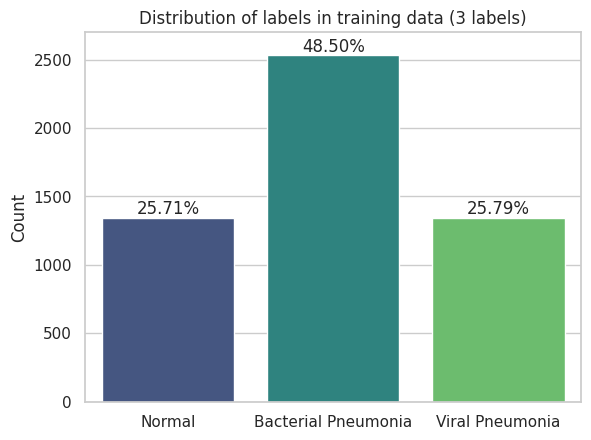

In [7]:
ax = sns.countplot(x=train_labels_all_types, palette="viridis")
plt.title("Distribution of labels in training data (3 labels)")
plt.xticks(ticks=[0, 1, 2], labels=["Normal", "Bacterial Pneumonia", "Viral Pneumonia"])
plt.ylabel("Count")
plt.ylim(0, 2700)
# see https://stackoverflow.com/questions/76240680/how-do-i-add-a-percentage-to-a-countplot
ax.bar_label(ax.containers[0], fmt=lambda x: f"{x/len(train_labels) * 100:.2f}%")
ax.bar_label(ax.containers[1], fmt=lambda x: f"{x/len(train_labels) * 100:.2f}%")
ax.bar_label(ax.containers[2], fmt=lambda x: f"{x/len(train_labels) * 100:.2f}%")

Thus, a total of 74.29% of all images are labeled as "Pneumonia" and 25.71% of all images are labeled as "Normal". Around two thirds of the Pneumonia labels are Bacterial Pneumonia and only one third are viral Pneumonia. Thus, there is a significant class imbalance in the train dataset which might lead to a **bias** in our model. We will have to consider this in the model building process and the later stages of our analysis.

We redo the same plots for the validation set:

[Text(0, 0, '50.00%')]

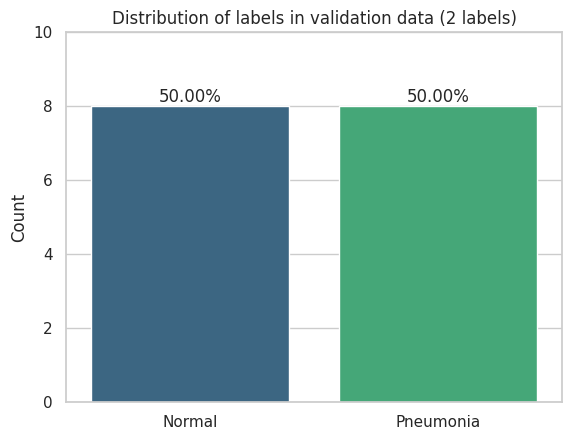

In [8]:
ax = sns.countplot(x=val_labels, palette="viridis")
plt.title("Distribution of labels in validation data (2 labels)")
plt.xticks(ticks=[0, 1], labels=["Normal", "Pneumonia"])
plt.ylabel("Count")
plt.ylim(0, 10)
# see https://stackoverflow.com/questions/76240680/how-do-i-add-a-percentage-to-a-countplot
ax.bar_label(ax.containers[0], fmt=lambda x: f"{x/len(val_labels) * 100:.2f}%")
ax.bar_label(ax.containers[1], fmt=lambda x: f"{x/len(val_labels) * 100:.2f}%")

[Text(0, 0, '50.00%')]

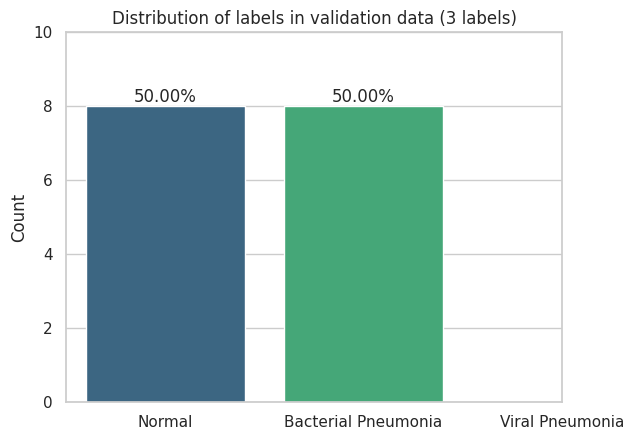

In [9]:
ax = sns.countplot(x=val_labels_all_types, palette="viridis")
plt.title("Distribution of labels in validation data (3 labels)")
plt.xticks(ticks=[0, 1, 2], labels=["Normal", "Bacterial Pneumonia", "Viral Pneumonia"])
plt.ylabel("Count")
plt.ylim(0, 10)
# see https://stackoverflow.com/questions/76240680/how-do-i-add-a-percentage-to-a-countplot
ax.bar_label(ax.containers[0], fmt=lambda x: f"{x/len(val_labels) * 100:.2f}%")
ax.bar_label(ax.containers[1], fmt=lambda x: f"{x/len(val_labels) * 100:.2f}%")

Thus, our validation set consists only of normal and Bacterial Pneumonia images. The very limited size and the lack of Viral Pneumonia images in the validation set have to be kept in the back of our minds when analyzing the model performance on the validation set. Thus, for the subsequent tasks, we will enlargen the validation set with some images from the training set. Additionally, manual <span style = "color:red">visual inspection of some of the validation set Pneumonia images revealed that some have the label 'A-P'in the top left corner </span>. Thus, we have to pay attention to get rid of this label in the preprocessing step such that the model does not just learn the label in the image.

## Visual Inspection

Let's have a look at some images of each class:

Text(0.5, 0.98, 'Sample images from training data (2 labels)')

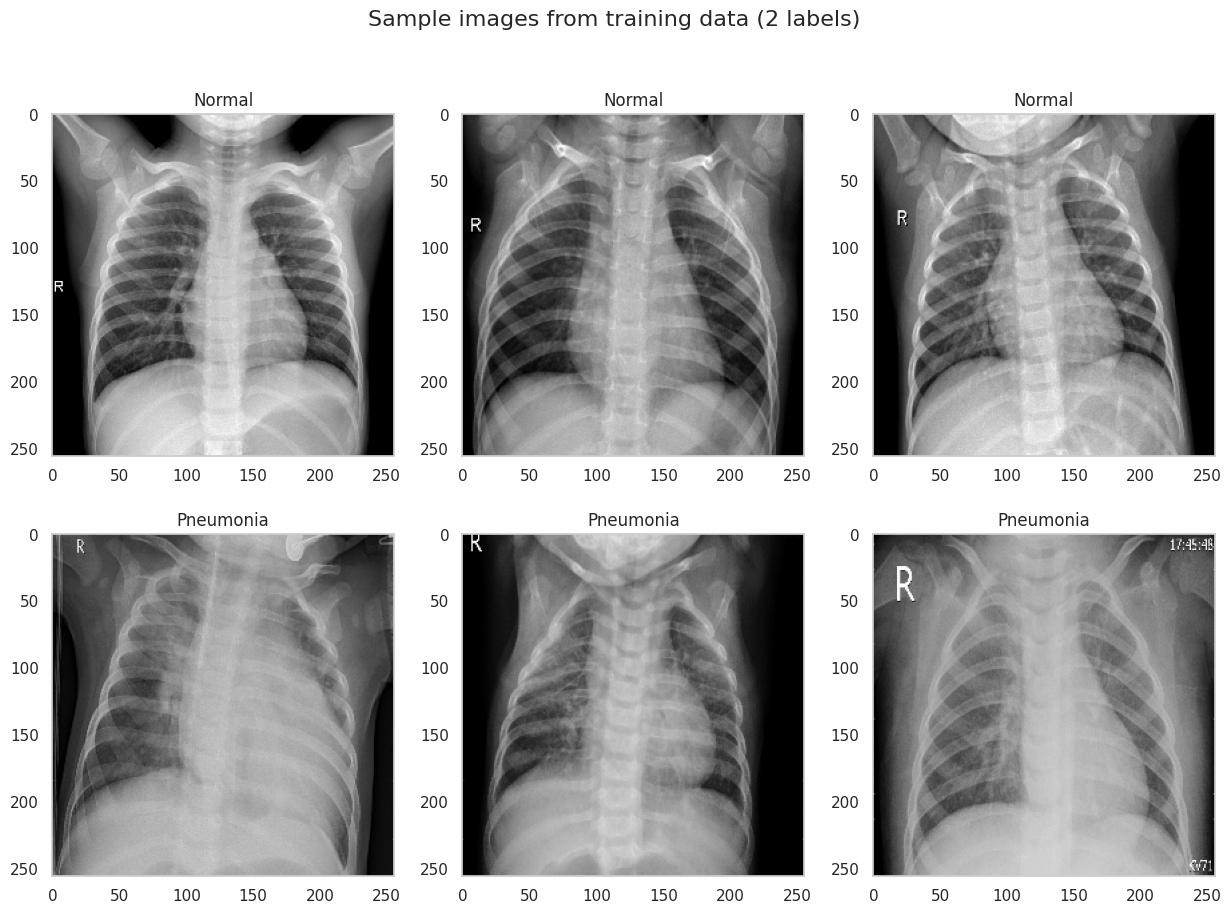

In [10]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten()

for i, label in enumerate(["Normal", "Pneumonia"]):
    for j in range(3):
        
        # for all images of a label a separate row
        ax = axs[3 * i + j]
        
        ax.imshow(train_images[np.where(train_labels == i)[0]][j], cmap="gray")
        ax.set_title(f"{label}")
        # remove grid lines
        ax.grid(False)
fig.suptitle("Sample images from training data (2 labels)", fontsize=16)

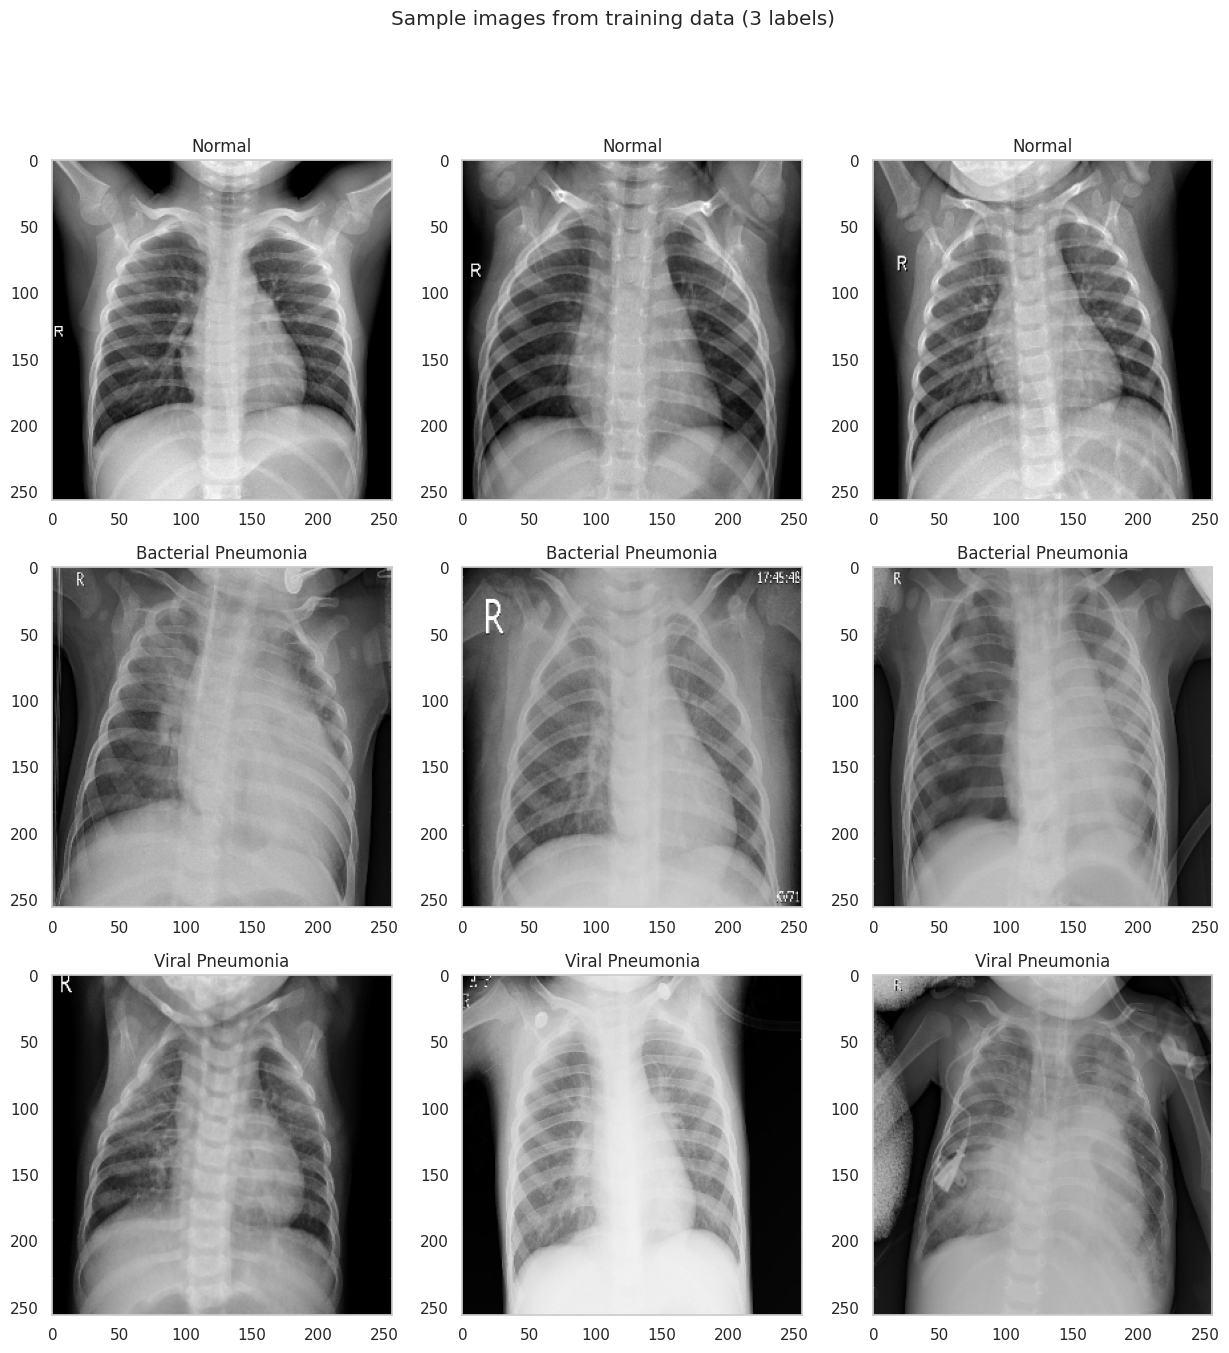

In [11]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
axs = axs.flatten()

fig.suptitle("Sample images from training data (3 labels)")
for i, label in enumerate(["Normal", "Bacterial Pneumonia", "Viral Pneumonia"]):
    for j in range(3):
        # for all images of a label a separate row
        ax = axs[3 * i + j]
        ax.imshow(
            train_images_all_types[np.where(train_labels_all_types == i)[0]][j],
            cmap="gray",
        )
        ax.set_title(f"{label}")
        # remove grid lines
        ax.grid(False)

We can see that most of the images have a small R somewhere. Moreover, manual visual inspection of a selection of images revealed that some of the x-ray images belonging to the Pneumonia class have the label 'A-P' in the top left corner. Thus, we need to remove these labels in our preprocessing. 

As for differences between images of different classes, we can see that the images of the "Normal" class are generally more clear and less blurry with less white areas than the images of the Pneumonia class. Also, it is easier to distinguish the heart from the lungs in the "Normal" class images.

## Preprocessing
See the [pytorch documentation](https://pytorch.org/vision/stable/transforms.html) for a more extensive list of available transformations. Note that transformations below are the same as the ones used in the following [kaggle](https://www.kaggle.com/code/teyang/pneumonia-detection-resnets-pytorch) post.

1. **Resizing**: The images have different sizes. When loading the images we will all scale them to (256, 256). Note that (256, 256) is arbitrary but is often chosen in image classifacation tasks involving CNNs.
2. **Center Crop**: Crop the images to (224, 224) to crop out the labels that are in the corners of some images.
3. **Random Rotation**: Rotate the images by max. 10 degrees to make the model more robust to different orientations of the x-ray images.
4. **Random Horizontal Flip**: Flip the images horizontally to make the model more robust to different orientations of the x-ray images.
5. **Random Gray Scale**: Make model more robust against different color scales in the x-ray images (and to make arrows less visible that are sometimes presents as seen in the example images on [kaggle](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/data)).
6. **Convert To Tensor**: Finally, convert the images to tensor (automatically converts all pixel values to values between 0 and 1).